## Data processing and ARIMA modelling

In [40]:
#Import scklearn modules
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

#Statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#Import matplot
import matplotlib.pyplot as plt

#Load additional packages
import time
import datetime
import numpy as np
import pandas as pd
import requests
from collections import Counter
import itertools
import re
import sys
from retry import retry
import os
import dotenv
import pickle

pd.set_option('display.max_colwidth', None)
%matplotlib inline

### Define Functions

Function to convert timestamp to a datetime object

In [3]:
def to_time(t):
    date_time_obj = datetime.datetime.strptime(t,'%Y-%m-%d %H:%M:%S').date()
    return date_time_obj

Function to interpret the dicky fuller test results

In [4]:
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2],index=['Test Statistic','p-value'])
    return dfoutput

Function to classify and count mentions of a given stock

In [5]:
def classify(word,stock):
    if word == stock:
        return 1
    else:
        return 0

### Import twitter data for modelling

In [19]:
merge = pd.read_csv('data/twitter_historical_merge.csv')
merge.set_index('date',inplace=True)
merge.sort_index(inplace=True)
merge.dropna(inplace=True)
merge.index = pd.to_datetime(merge.index)

### Modelling

Check for stationarity. Set alpha = 0.05 prior to conducting adfuller test.

In [21]:
interpret_dftest(adfuller(merge['price']))

Test Statistic   -3.017098
p-value           0.033328
dtype: float64

Thus we can reject the null hypothesis and our original data is stationary

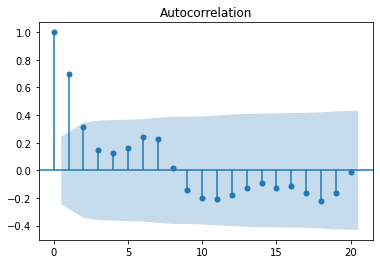

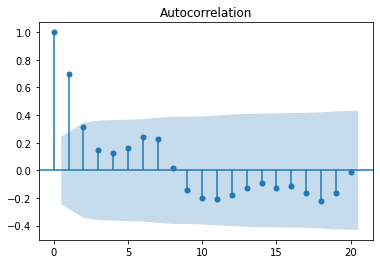

In [22]:
plot_acf(merge['mentions'],lags=20)

- Observations that are 1 lag apart have a correlation of ~0.55 (k=1)
- There is no statsitically relevance in the correlations of other lags

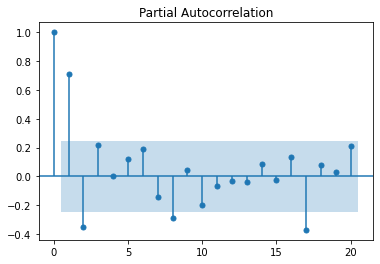

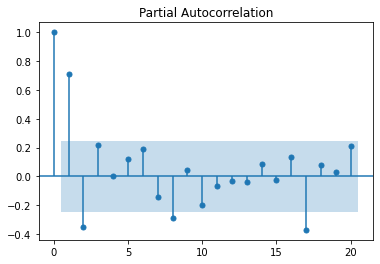

In [23]:
plot_pacf(merge['mentions'],lags=20)

Therefore select p=1 

### Train-test split the data for time series modelling

In [43]:
X_train,X_test,y_train,y_test = train_test_split(merge['mentions'],
                                                merge['price'],
                                                test_size=0.3,
                                                shuffle=False)

Fit the model

In [48]:
model = ARIMA(endog = y_train,
             order=(1,0,0))

arima_1_0_0 = model.fit()

y_test.head()

/Users/noahz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/noahz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so 

date
2021-02-14    49.51
2021-02-15    49.51
2021-02-16    49.51
2021-02-17    45.94
2021-02-18    40.69
Name: price, dtype: float64

In [49]:
preds = model.predict(params=arima_1_0_0.params,start = datetime.datetime(2021,2,14),end = datetime.datetime(2021,3,5))
preds

array([55.86618211, 58.65358517, 60.89513382, 62.69772219, 64.14731145,
       65.31302907, 66.25046535, 67.0043244 , 67.61055597, 68.0980698 ,
       68.49011428, 68.80538507, 69.0589167 , 69.26279947, 69.42675608,
       69.55860523, 69.66463449, 69.74990014, 69.8184683 , 69.87360883])

Plot the model predictions vs. actuals

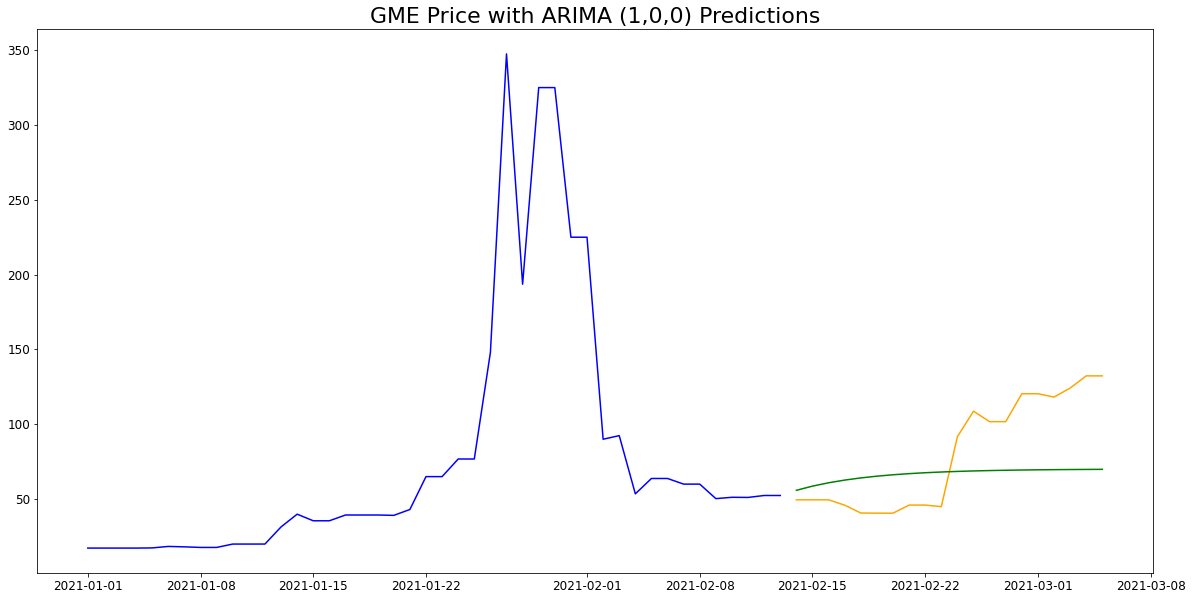

In [50]:
plt.figure(figsize=(20,10))

plt.plot(y_train.index,y_train,color='blue')

plt.plot(y_test.index,y_test,color='orange')

plt.plot(y_test.index,preds,color='green')

plt.title(label = 'GME Price with ARIMA (1,0,0) Predictions',fontsize=22)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [51]:
mean_squared_error(y_test,preds)

1318.3217169984662

### Export the ARIMA model

In [42]:
#save model to disk
filename = 'assets/ARIMA_model.csv'
pickle.dump(model,open(filename,'wb'))

### Reccurrent Neural Network Model data prep/export

In [33]:
merge['target'] = merge['price'].diff(5).apply(lambda r: 1 if r >0 else 0)

In [34]:
merge.head(20)

,mentions,followers,price,target
date,,,,
2021-01-01,2.0,1.720597e+09,17.25,0
2021-01-02,1.0,1.633288e+09,17.25,0
2021-01-03,2.0,1.043636e+09,17.25,0
2021-01-04,2.0,1.760137e+09,17.25,0
2021-01-05,2.0,2.277719e+09,17.37,0
2021-01-06,1.0,1.621527e+09,18.36,1
2021-01-07,3.0,2.278927e+09,18.08,1
2021-01-08,2.0,2.059609e+09,17.69,1
2021-01-09,3.0,2.015346e+09,17.69,1


In [35]:
merge.to_csv('data/data_rnn.csv')